In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error

from sklearn.impute import SimpleImputer
import time
from tqdm import tqdm

전체적인 모델학습 파이프라인
1. 데이터 스케일링
2. 모델 구현
3. 학습
4. 결과값 예측 및 실제값과 예측값간 차이 계산

# 1.데이터 전처리

In [ ]:
df_ks = pd.read_csv("/content/drive/MyDrive/공모전/DB경제/LSTM/KOSPI.csv")
df_sp = pd.read_csv("/content/drive/MyDrive/공모전/DB경제/LSTM/SP500.csv")

In [ ]:
ks = df_ks["Adj Close"].to_frame() #학습에는 종가 조정 가격 사용

In [ ]:
sp = df_sp["Adj Close"].to_frame()

In [ ]:
ks.isnull().sum() #Null 값 확인

Adj Close    104
dtype: int64

In [ ]:
 sp.isnull().sum() 

Adj Close    0
dtype: int64

In [ ]:
ks = ks.dropna()

In [ ]:
def percentage(data):

  result = []
  
  for i in range(len(data)-1):

    percentage_change = (data[i+1]-data[i]) / data[i]
    result.append(percentage_change)

  return np.array(result)

Text(0.5, 1.0, 'KOSPI & S&P 500')

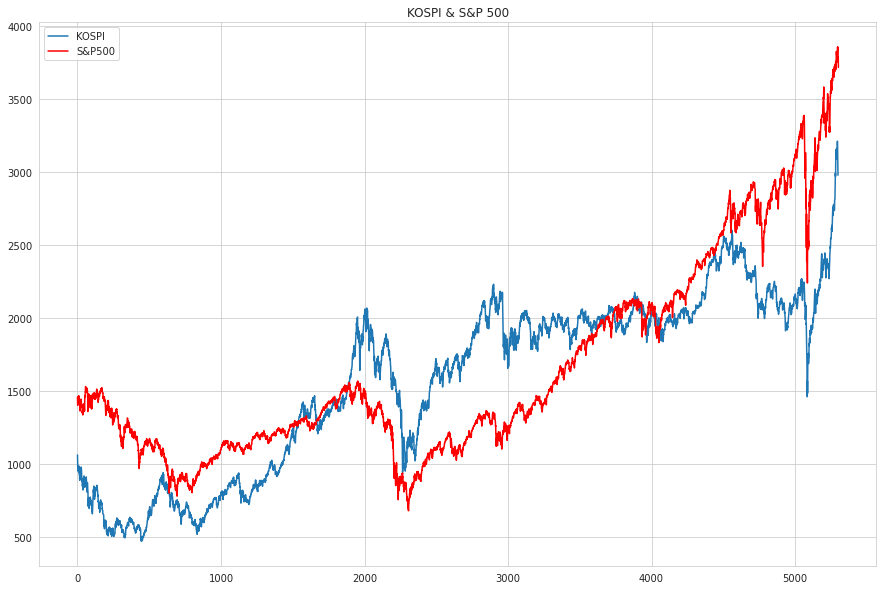

In [ ]:
sns.set_style("whitegrid")
fig = plt.figure(figsize=(15,10))
ax = fig.subplots(1,1)
ax.plot(ks,label="KOSPI")
ax.plot(sp,c="r",label="S&P500")
ax.legend(fontsize=10)
ax.set_title("KOSPI & S&P 500",fontsize=12)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
scaler = MinMaxScaler(feature_range=(0,1))

ks_scaled = pd.DataFrame(scaler.fit_transform(ks),columns=ks.columns)
sp_scaled = pd.DataFrame(scaler.fit_transform(sp),columns=ks.columns)

Text(0.5, 1.0, 'KOSPI & S&P 500 Scaled')

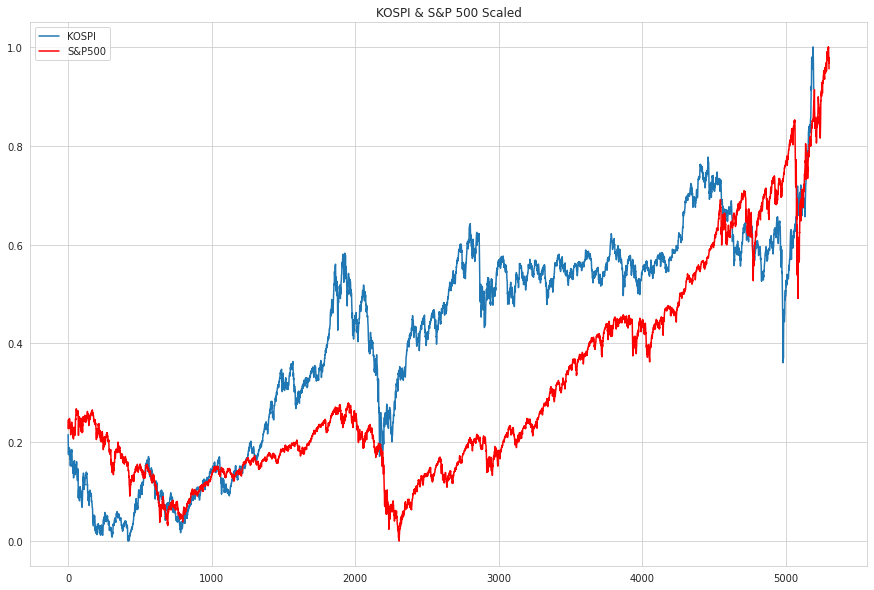

In [ ]:
sns.set_style("whitegrid")
fig = plt.figure(figsize=(15,10))
ax = fig.subplots(1,1)
ax.plot(ks_scaled,label="KOSPI")
ax.plot(sp_scaled,c="r",label="S&P500")
ax.legend(fontsize=10)
ax.set_title("KOSPI & S&P 500 Scaled",fontsize=12)

# 2.코스피 지수 예측 모델 정의


In [ ]:
from keras.layers import LSTM
from keras.layers import Dense
from keras.models import Sequential
from keras import optimizers 
import tensorflow as tf

from keras.models import load_model
from keras.callbacks import ModelCheckpoint

In [ ]:
def make_dataset(data,window_size):#데이터를 Step_size로 나눠주는 함수 정의

  X = []
  y = []

  for i in range(len(data)):

    end = i+window_size

    if end > len(data)-1:

      break
    
    X_window = data[i:end]
    y_window = data[end]

    X.append(X_window)
    y.append(y_window)

  return np.array(X),np.array(y)

In [ ]:
mc = ModelCheckpoint("best_model.h5",monitor="val_loss",mode="min",save_best_only=True,verbose=1) #성능이 가장 좋은 모델 저장

In [ ]:
X,y = make_dataset(ks_scaled.values,30)

In [ ]:
X.shape, y.shape

((5166, 30, 1), (5166, 1))

In [ ]:
X_train_ks,y_train_ks = X[:4000],y[:4000] #학습용 데이터
X_val_ks,y_val_ks = X[4000:4436],y[4000:4436] #검증용 데이터
X_test_ks,y_test_ks = X[4436:5166],y[4436:5166] #테스트용 데이터

In [ ]:
#5번에 걸쳐서 학습진행, 각 모델의 결과값 저장

ks_result = np.zeros((730,1)) #모델 결과값 저장하기 위한 730:1 모양의 행렬 생성

with tf.device('/device:GPU:0'):

  for i in tqdm(range(0,5)):
    
    # 모델 정의, 80 LSTM CELLS, 3 Stacked Layer
    model = Sequential()
    model.add(LSTM(80,input_shape=(30,1),return_sequences=True,activation="tanh"))
    model.add(LSTM(80,input_shape=(30,1),return_sequences=True,activation="tanh"))
    model.add(LSTM(80,input_shape=(30,1),activation="tanh"))
    model.add(Dense(1))
    optimizer = optimizers.RMSprop(learning_rate=0.003)

    model.compile(optimizer=optimizer,loss="mse")
    hist = model.fit(X_train_ks,y_train_ks,epochs=200,callbacks=[mc],validation_data=(X_val_ks,y_val_ks),batch_size=64)
    
    best_model = load_model("/content/best_model.h5") # 가장 성능 좋은 모델 저장
    
    pred = best_model.predict(X_test_ks).reshape(-1,1) # 가장 성능 좋은 모델로 테스트용 데이터(2019~2020년 데이터) 예측
    ks_result = np.hstack([ks_result,pred]) # 730개의 예측한 데이터를 최초에 정의한 730:1 모양의 행렬에 행 기준으로 붙임
    time.sleep(0.1)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/200
63/63 [==============================] - 5s 29ms/step - loss: 0.0578 - val_loss: 0.0509

Epoch 00001: val_loss improved from inf to 0.05091, saving model to best_model.h5
Epoch 2/200
63/63 [==============================] - 1s 10ms/step - loss: 0.0069 - val_loss: 0.0177

Epoch 00002: val_loss improved from 0.05091 to 0.01767, saving model to best_model.h5
Epoch 3/200
63/63 [==============================] - 1s 10ms/step - loss: 0.0041 - val_loss: 7.7161e-04

Epoch 00003: val_loss improved from 0.01767 to 0.00077, saving model to best_model.h5
Epoch 4/200
63/63 [==============================] - 1s 10ms/step - loss: 0.0025 - val_loss: 7.7080e-04

Epoch 00004: val_loss improved from 0.00077 to 0.00077, saving model to best_model.h5
Epoch 5/200
63/63 [==============================] - 1s 10ms/step - loss: 0.0020 - val_loss: 0.0031

Epoch 00005: val_loss did not improve from 0.00077
Epoch 6/200
63/63 [==============================] - 1s 10ms/step - loss: 0.0021 - val_loss: 0.0

 20%|██        | 1/5 [02:15<09:03, 135.82s/it]

Epoch 1/200
63/63 [==============================] - 5s 23ms/step - loss: 0.0684 - val_loss: 0.0018

Epoch 00001: val_loss did not improve from 0.00009
Epoch 2/200
63/63 [==============================] - 1s 10ms/step - loss: 0.0068 - val_loss: 0.0323

Epoch 00002: val_loss did not improve from 0.00009
Epoch 3/200
63/63 [==============================] - 1s 10ms/step - loss: 0.0042 - val_loss: 0.0165

Epoch 00003: val_loss did not improve from 0.00009
Epoch 4/200
63/63 [==============================] - 1s 10ms/step - loss: 0.0029 - val_loss: 0.0108

Epoch 00004: val_loss did not improve from 0.00009
Epoch 5/200
63/63 [==============================] - 1s 14ms/step - loss: 0.0019 - val_loss: 0.0012

Epoch 00005: val_loss did not improve from 0.00009
Epoch 6/200
63/63 [==============================] - 1s 10ms/step - loss: 0.0015 - val_loss: 0.0103

Epoch 00006: val_loss did not improve from 0.00009
Epoch 7/200
63/63 [==============================] - 1s 10ms/step - loss: 0.0015 - val_l

 40%|████      | 2/5 [04:29<06:45, 135.20s/it]

Epoch 1/200
63/63 [==============================] - 5s 23ms/step - loss: 0.0615 - val_loss: 0.0790

Epoch 00001: val_loss did not improve from 0.00009
Epoch 2/200
63/63 [==============================] - 1s 10ms/step - loss: 0.0065 - val_loss: 0.0016

Epoch 00002: val_loss did not improve from 0.00009
Epoch 3/200
63/63 [==============================] - 1s 10ms/step - loss: 0.0033 - val_loss: 0.0164

Epoch 00003: val_loss did not improve from 0.00009
Epoch 4/200
63/63 [==============================] - 1s 10ms/step - loss: 0.0027 - val_loss: 0.0162

Epoch 00004: val_loss did not improve from 0.00009
Epoch 5/200
63/63 [==============================] - 1s 10ms/step - loss: 0.0018 - val_loss: 0.0025

Epoch 00005: val_loss did not improve from 0.00009
Epoch 6/200
63/63 [==============================] - 1s 10ms/step - loss: 0.0017 - val_loss: 8.9182e-04

Epoch 00006: val_loss did not improve from 0.00009
Epoch 7/200
63/63 [==============================] - 1s 10ms/step - loss: 0.0014 - v

 60%|██████    | 3/5 [06:46<04:31, 135.71s/it]

Epoch 1/200
63/63 [==============================] - 5s 23ms/step - loss: 0.1223 - val_loss: 0.0032

Epoch 00001: val_loss did not improve from 0.00009
Epoch 2/200
63/63 [==============================] - 1s 10ms/step - loss: 0.0071 - val_loss: 0.0082

Epoch 00002: val_loss did not improve from 0.00009
Epoch 3/200
63/63 [==============================] - 1s 10ms/step - loss: 0.0041 - val_loss: 0.0066

Epoch 00003: val_loss did not improve from 0.00009
Epoch 4/200
63/63 [==============================] - 1s 10ms/step - loss: 0.0038 - val_loss: 0.0023

Epoch 00004: val_loss did not improve from 0.00009
Epoch 5/200
63/63 [==============================] - 1s 10ms/step - loss: 0.0021 - val_loss: 0.0018

Epoch 00005: val_loss did not improve from 0.00009
Epoch 6/200
63/63 [==============================] - 1s 10ms/step - loss: 0.0014 - val_loss: 0.0065

Epoch 00006: val_loss did not improve from 0.00009
Epoch 7/200
63/63 [==============================] - 1s 10ms/step - loss: 0.0016 - val_l

 80%|████████  | 4/5 [09:04<02:16, 136.34s/it]

Epoch 1/200
63/63 [==============================] - 5s 24ms/step - loss: 0.0508 - val_loss: 0.0283

Epoch 00001: val_loss did not improve from 0.00004
Epoch 2/200
63/63 [==============================] - 1s 10ms/step - loss: 0.0064 - val_loss: 0.0024

Epoch 00002: val_loss did not improve from 0.00004
Epoch 3/200
63/63 [==============================] - 1s 10ms/step - loss: 0.0032 - val_loss: 0.0168

Epoch 00003: val_loss did not improve from 0.00004
Epoch 4/200
63/63 [==============================] - 1s 10ms/step - loss: 0.0031 - val_loss: 0.0167

Epoch 00004: val_loss did not improve from 0.00004
Epoch 5/200
63/63 [==============================] - 1s 10ms/step - loss: 0.0020 - val_loss: 0.0169

Epoch 00005: val_loss did not improve from 0.00004
Epoch 6/200
63/63 [==============================] - 1s 10ms/step - loss: 0.0014 - val_loss: 0.0014

Epoch 00006: val_loss did not improve from 0.00004
Epoch 7/200
63/63 [==============================] - 1s 10ms/step - loss: 0.0017 - val_l

100%|██████████| 5/5 [11:24<00:00, 136.91s/it]


In [ ]:
test_ks = np.mean(ks_result[:731,1:],axis=1).reshape(-1,1) # 5번 학습 진행한 결과값 평균

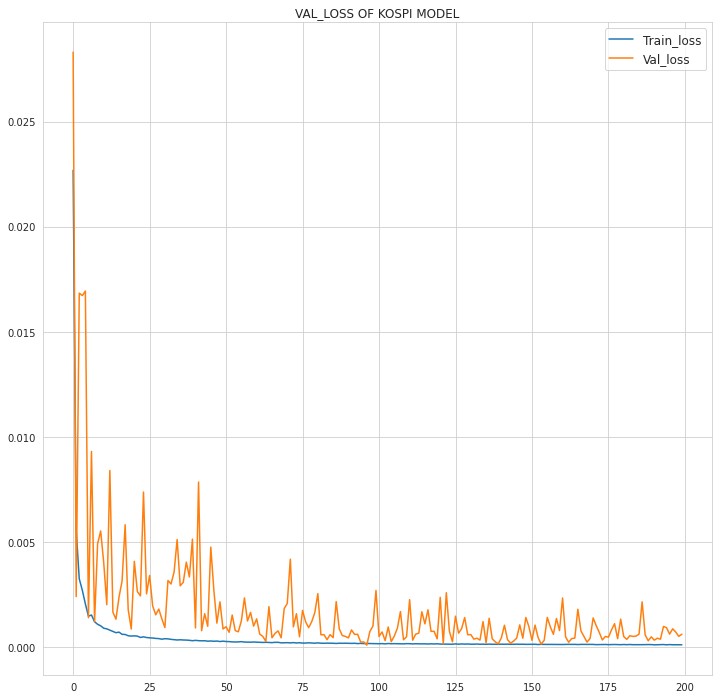

In [ ]:
# 모델 Train loss, Valid loss 차트

fig = plt.figure(figsize=(12,12))

plt.plot(hist.history["loss"],label="Train_loss")
plt.plot(hist.history["val_loss"],label="Val_loss")
plt.title("VAL_LOSS OF KOSPI MODEL",fontsize=12)
plt.legend(fontsize=12)

Text(0.5, 1.0, 'KOSPI TEST RESULT')

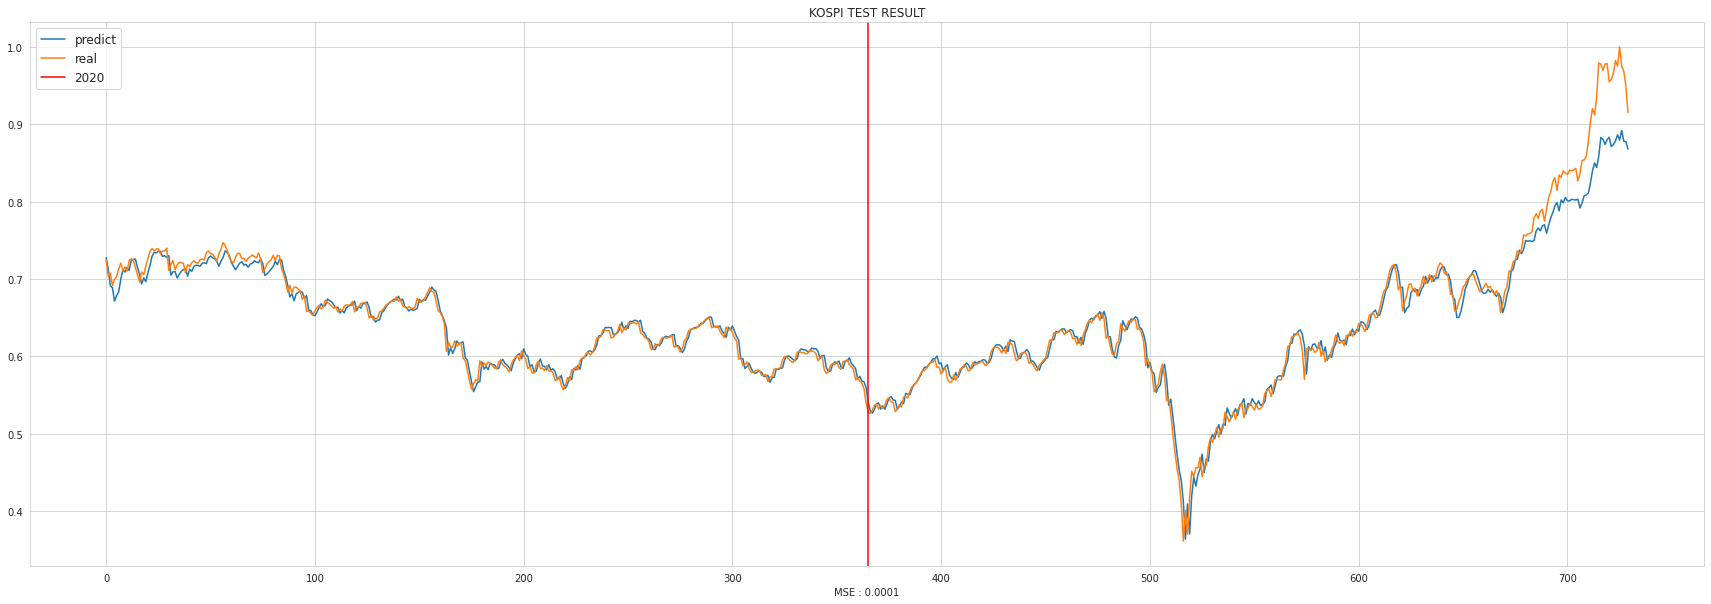

In [ ]:
#2019~2020년 테스트용 데이터를 모델에 넣은 결과값

plt.figure(figsize=(30,10))

plt.plot(test_ks,label="predict")
plt.plot(y_test_ks,label="real")
plt.axvline(x=365, ymin=0, ymax=1,c="red",label="2020")
plt.legend(fontsize=12)
plt.xlabel("MSE : {}".format(np.round(mean_squared_error(y_test_ks[:366],test_ks[:366]),4)))
plt.title("KOSPI TEST RESULT",fontsize=12)

In [ ]:
print(np.round(mean_squared_error(y_test_ks[:366],test_ks[:366]),4)) #2019년 테스트 데이터에 대한 Loss

0.0001


Text(0.5, 1.0, 'Difference between Real and predicted data by lstm')

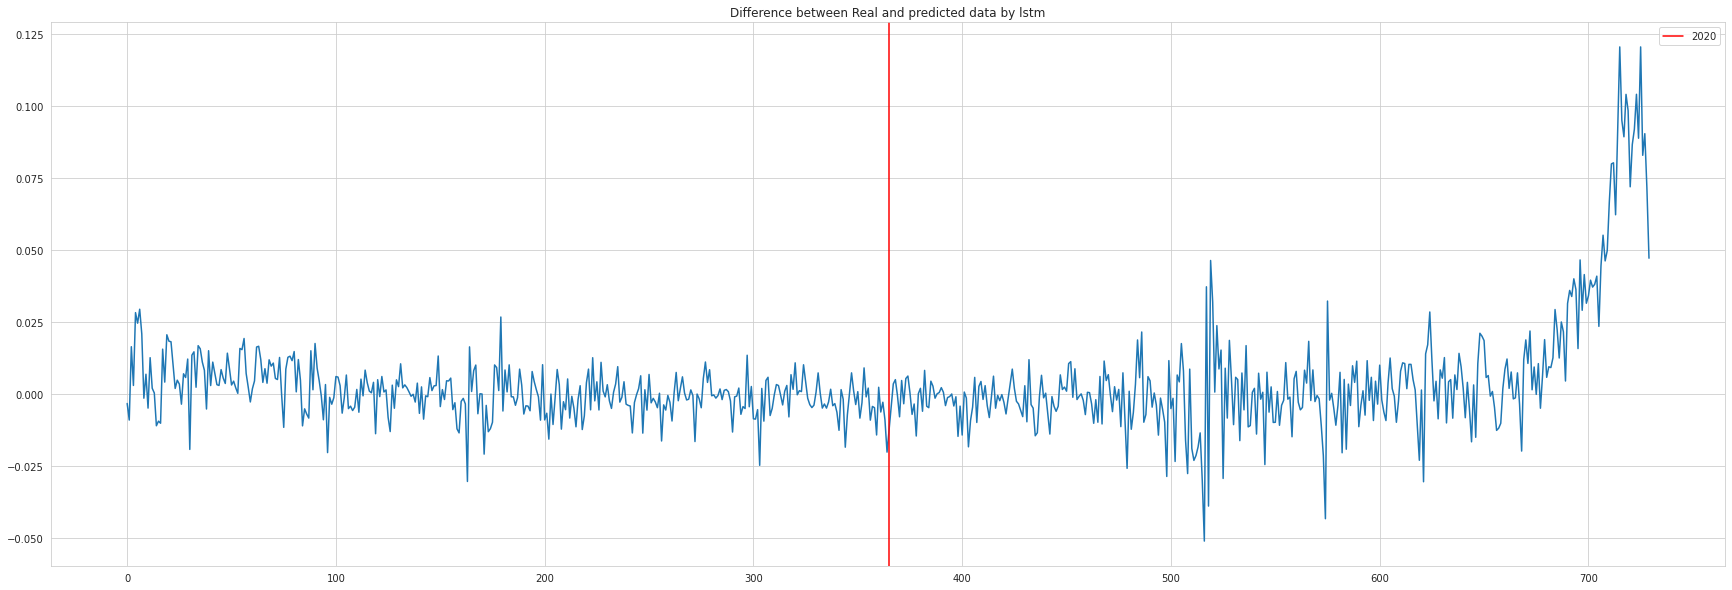

In [ ]:
fig = plt.figure(figsize=(30,10))
ks_diff = y_test_ks - np.array(test_ks) #실제값-예측값(버블)
plt.plot(ks_diff)
plt.axvline(x=365, ymin=0, ymax=1,c="red",label="2020")
plt.legend()
plt.title("Difference between Real and predicted data by lstm")

Text(0.5, 1.0, 'Percentage Change between real and predict data')

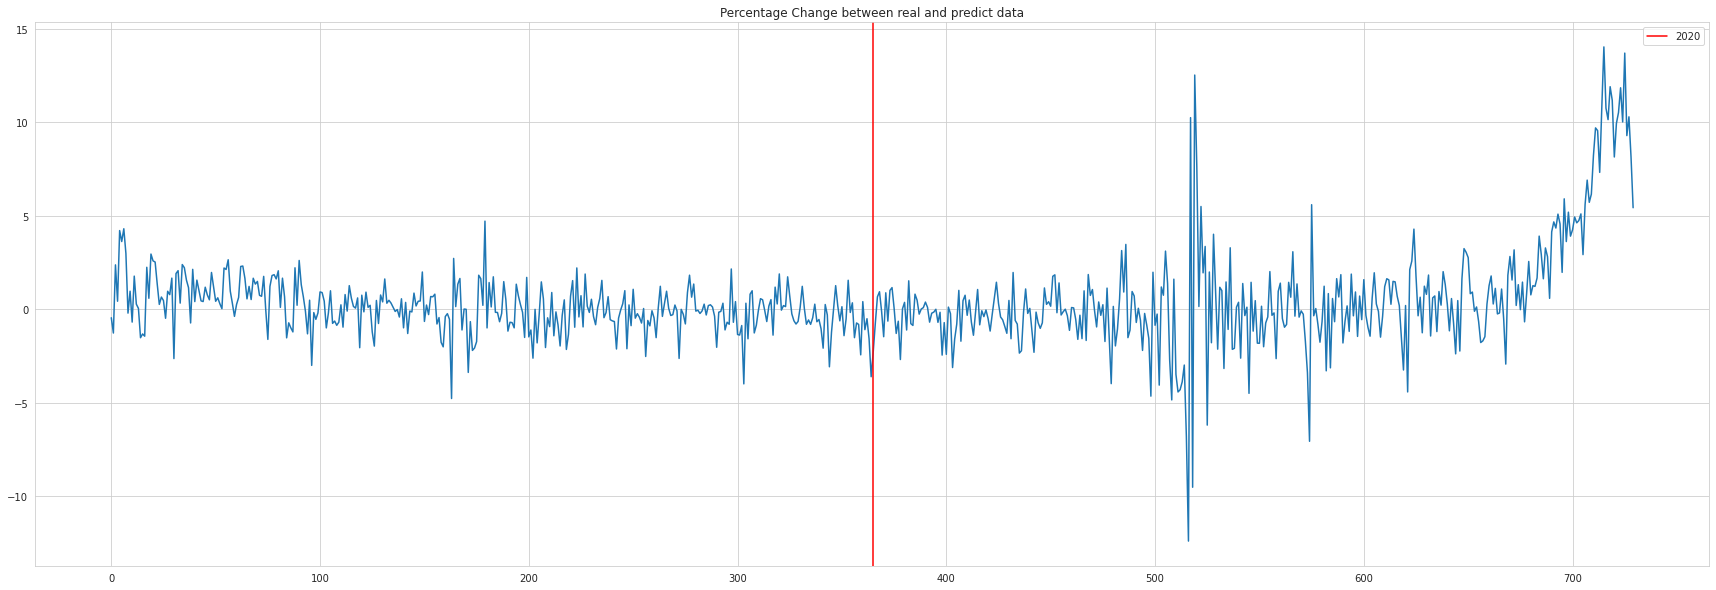

In [ ]:
ks_diff_percentage = ks_diff / test_ks*100 # 실제-예측 퍼센트화

fig = plt.figure(figsize=(30,10))
plt.plot(ks_diff_percentage)
plt.axvline(x=365, ymin=0, ymax=1,c="red",label="2020")
plt.legend()
plt.title("Percentage Change between real and predict data")

# 3.S&P500 지수 예측 모델 정의


In [ ]:
# 코스피 지수 학습과 파이프 라인 동일

X,y = make_dataset(sp_scaled.values,30)

In [ ]:
X.shape,y.shape

((5273, 30, 1), (5273, 1))

In [ ]:
X_train_sp,y_train_sp = X[:4200],y[:4200]
X_val_sp,y_val_sp = X[4200:4543],y[4200:4543]
X_test_sp,y_test_sp = X[4543:],y[4543:]

In [ ]:
mc2 = ModelCheckpoint("best_model2.h5",monitor="val_loss",mode="min",save_best_only=True,verbose=1)

In [ ]:
sp_result = np.zeros((730,1))

with tf.device('/device:GPU:0'):

  for i in tqdm(range(0,5)):
    
    #80 LSTM Cells, 2 stacked layers
    model = Sequential()
    model.add(LSTM(80,input_shape=(30,1),return_sequences=True,activation="tanh"))
    model.add(LSTM(80,input_shape=(30,1),return_sequences=False,activation="tanh"))
    model.add(Dense(1))
    optimizer = optimizers.RMSprop(learning_rate=0.003)

    model.compile(optimizer=optimizer,loss="mse")
    hist = model.fit(X_train_sp,y_train_sp,epochs=200,callbacks=[mc2],validation_data=(X_val_sp,y_val_sp),batch_size=64)
    
    best_model2 = load_model("/content/best_model2.h5")
    
    pred = best_model2.predict(X_test_sp).reshape(-1,1)
    sp_result = np.hstack([sp_result,pred])
    time.sleep(0.1)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/200
66/66 [==============================] - 3s 17ms/step - loss: 0.0305 - val_loss: 0.0816

Epoch 00001: val_loss improved from inf to 0.08157, saving model to best_model2.h5
Epoch 2/200
66/66 [==============================] - 0s 7ms/step - loss: 0.0032 - val_loss: 0.0010

Epoch 00002: val_loss improved from 0.08157 to 0.00101, saving model to best_model2.h5
Epoch 3/200
66/66 [==============================] - 0s 7ms/step - loss: 0.0016 - val_loss: 5.9128e-04

Epoch 00003: val_loss improved from 0.00101 to 0.00059, saving model to best_model2.h5
Epoch 4/200
66/66 [==============================] - 0s 7ms/step - loss: 9.4698e-04 - val_loss: 0.0026

Epoch 00004: val_loss did not improve from 0.00059
Epoch 5/200
66/66 [==============================] - 0s 7ms/step - loss: 8.6950e-04 - val_loss: 2.5938e-04

Epoch 00005: val_loss improved from 0.00059 to 0.00026, saving model to best_model2.h5
Epoch 6/200
66/66 [==============================] - 0s 7ms/step - loss: 6.1860e-04 - va

 20%|██        | 1/5 [01:45<07:02, 105.58s/it]

Epoch 1/200
66/66 [==============================] - 4s 21ms/step - loss: 0.0240 - val_loss: 0.0159

Epoch 00001: val_loss did not improve from 0.00004
Epoch 2/200
66/66 [==============================] - 0s 7ms/step - loss: 0.0024 - val_loss: 0.0060

Epoch 00002: val_loss did not improve from 0.00004
Epoch 3/200
66/66 [==============================] - 0s 7ms/step - loss: 0.0015 - val_loss: 7.2114e-04

Epoch 00003: val_loss did not improve from 0.00004
Epoch 4/200
66/66 [==============================] - 0s 7ms/step - loss: 7.5566e-04 - val_loss: 4.5438e-04

Epoch 00004: val_loss did not improve from 0.00004
Epoch 5/200
66/66 [==============================] - 0s 7ms/step - loss: 8.2921e-04 - val_loss: 2.3056e-04

Epoch 00005: val_loss did not improve from 0.00004
Epoch 6/200
66/66 [==============================] - 0s 7ms/step - loss: 6.2248e-04 - val_loss: 0.0013

Epoch 00006: val_loss did not improve from 0.00004
Epoch 7/200
66/66 [==============================] - 0s 7ms/step - lo

 40%|████      | 2/5 [03:31<05:16, 105.55s/it]

Epoch 1/200
66/66 [==============================] - 4s 17ms/step - loss: 0.0248 - val_loss: 0.0145

Epoch 00001: val_loss did not improve from 0.00004
Epoch 2/200
66/66 [==============================] - 0s 8ms/step - loss: 0.0030 - val_loss: 4.1577e-04

Epoch 00002: val_loss did not improve from 0.00004
Epoch 3/200
66/66 [==============================] - 0s 7ms/step - loss: 0.0013 - val_loss: 4.9342e-04

Epoch 00003: val_loss did not improve from 0.00004
Epoch 4/200
66/66 [==============================] - 0s 8ms/step - loss: 0.0012 - val_loss: 2.9867e-04

Epoch 00004: val_loss did not improve from 0.00004
Epoch 5/200
66/66 [==============================] - 0s 7ms/step - loss: 7.1964e-04 - val_loss: 0.0024

Epoch 00005: val_loss did not improve from 0.00004
Epoch 6/200
66/66 [==============================] - 1s 8ms/step - loss: 7.1311e-04 - val_loss: 0.0017

Epoch 00006: val_loss did not improve from 0.00004
Epoch 7/200
66/66 [==============================] - 0s 7ms/step - loss: 

 60%|██████    | 3/5 [05:18<03:32, 106.05s/it]

Epoch 1/200
66/66 [==============================] - 3s 17ms/step - loss: 0.0175 - val_loss: 0.0316

Epoch 00001: val_loss did not improve from 0.00004
Epoch 2/200
66/66 [==============================] - 0s 7ms/step - loss: 0.0024 - val_loss: 0.0054

Epoch 00002: val_loss did not improve from 0.00004
Epoch 3/200
66/66 [==============================] - 0s 8ms/step - loss: 0.0012 - val_loss: 0.0044

Epoch 00003: val_loss did not improve from 0.00004
Epoch 4/200
66/66 [==============================] - 0s 7ms/step - loss: 7.1159e-04 - val_loss: 0.0106

Epoch 00004: val_loss did not improve from 0.00004
Epoch 5/200
66/66 [==============================] - 0s 7ms/step - loss: 7.2494e-04 - val_loss: 0.0021

Epoch 00005: val_loss did not improve from 0.00004
Epoch 6/200
66/66 [==============================] - 0s 7ms/step - loss: 4.9880e-04 - val_loss: 6.5148e-05

Epoch 00006: val_loss did not improve from 0.00004
Epoch 7/200
66/66 [==============================] - 1s 8ms/step - loss: 5.11

 80%|████████  | 4/5 [07:07<01:46, 106.90s/it]

Epoch 1/200
66/66 [==============================] - 3s 17ms/step - loss: 0.0251 - val_loss: 0.0052

Epoch 00001: val_loss did not improve from 0.00004
Epoch 2/200
66/66 [==============================] - 1s 8ms/step - loss: 0.0025 - val_loss: 0.0200

Epoch 00002: val_loss did not improve from 0.00004
Epoch 3/200
66/66 [==============================] - 0s 8ms/step - loss: 0.0017 - val_loss: 3.4029e-04

Epoch 00003: val_loss did not improve from 0.00004
Epoch 4/200
66/66 [==============================] - 0s 7ms/step - loss: 8.1248e-04 - val_loss: 0.0117

Epoch 00004: val_loss did not improve from 0.00004
Epoch 5/200
66/66 [==============================] - 0s 7ms/step - loss: 8.8150e-04 - val_loss: 0.0033

Epoch 00005: val_loss did not improve from 0.00004
Epoch 6/200
66/66 [==============================] - 0s 7ms/step - loss: 6.2103e-04 - val_loss: 7.9481e-04

Epoch 00006: val_loss did not improve from 0.00004
Epoch 7/200
66/66 [==============================] - 0s 7ms/step - loss: 

100%|██████████| 5/5 [08:56<00:00, 107.23s/it]


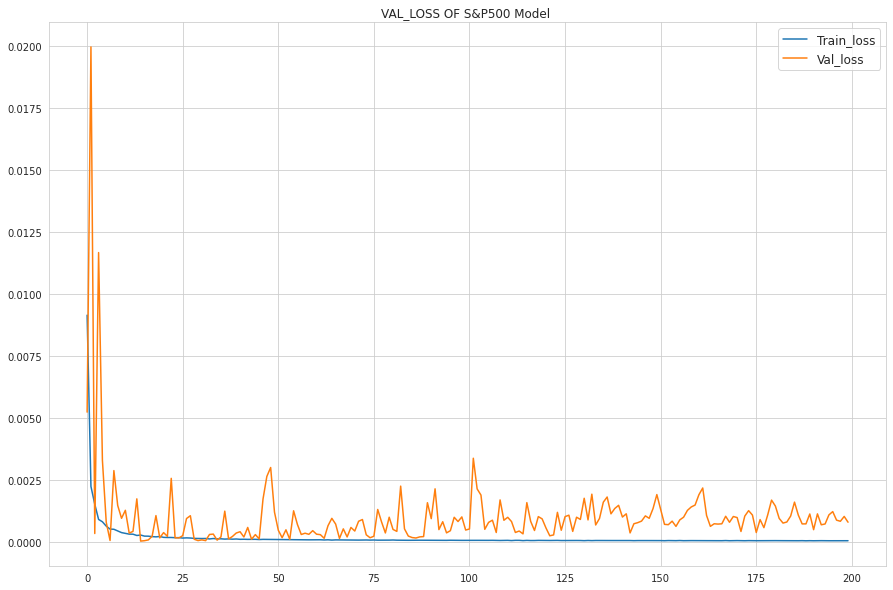

In [ ]:
plt.figure(figsize=(15,10))
plt.plot(hist.history["loss"],label="Train_loss")
plt.plot(hist.history["val_loss"],label="Val_loss")
plt.title("VAL_LOSS OF S&P500 Model ")
plt.legend(fontsize=12)

In [ ]:
test_sp = np.mean(sp_result[:731,1:],axis=1).reshape(-1,1) #예측값 평균

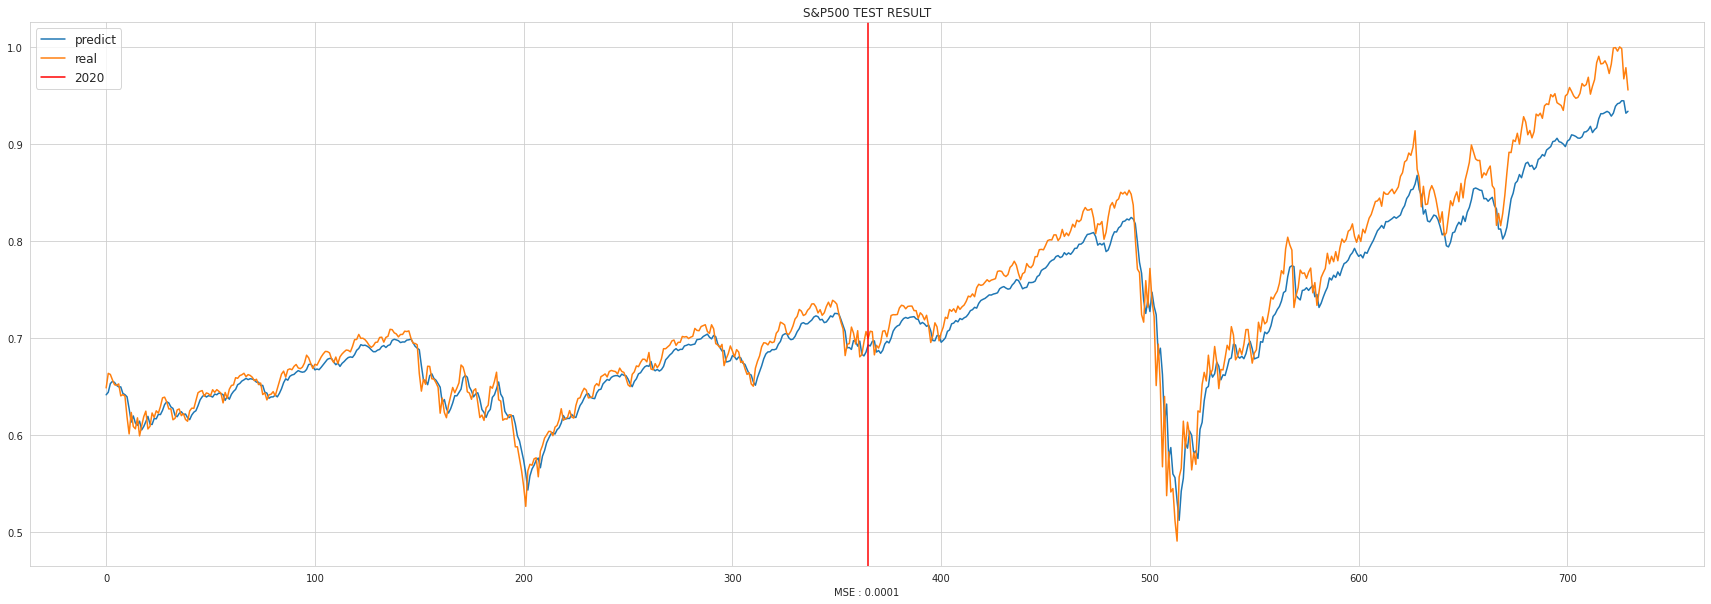

In [ ]:
plt.figure(figsize=(30,10))
plt.plot(test_sp,label="predict")
plt.plot(y_test_sp,label="real")
plt.axvline(x=365, ymin=0, ymax=1,c="red",label="2020")
plt.xlabel("MSE : {}".format(np.round(mean_squared_error(y_test_sp[:366],test_sp[:366]),4)))
plt.title("S&P500 TEST RESULT")
plt.legend(fontsize=12)

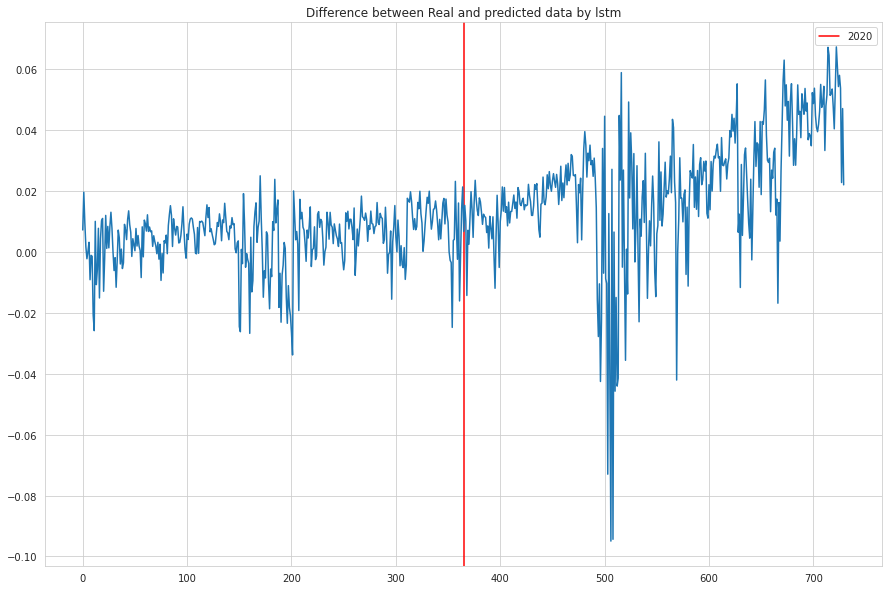

In [ ]:
sp_diff = y_test_sp - test_sp 
fig = plt.figure(figsize=(15,10))
plt.title("Difference between Real and predicted data by lstm")
plt.axvline(x=365, ymin=0, ymax=1,c="red",label="2020")
plt.legend()
plt.plot(sp_diff)

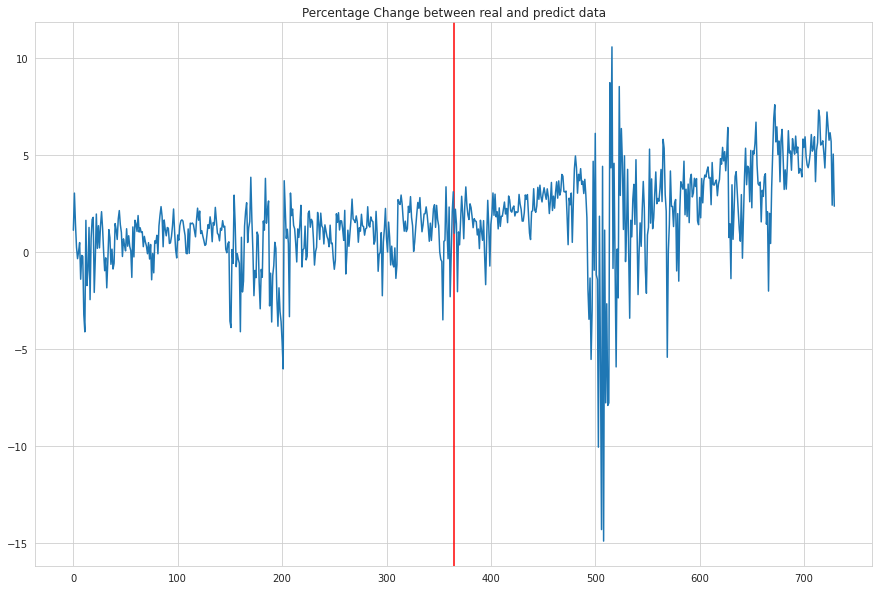

In [ ]:
sp_diff_percentage = sp_diff / test_sp * 100
fig = plt.figure(figsize=(15,10))
plt.title("Percentage Change between real and predict data")
plt.axvline(x=365, ymin=0, ymax=1,c="red",label="2020")
plt.plot(sp_diff_percentage)

In [ ]:
sp_per_slice = sp_diff_percentage[500:] #코로나 사태 이후 버블 관측치
ks_per_slice = ks_diff_percentage[500:]

In [ ]:
X=np.arange(1,231,1).reshape(-1,1)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


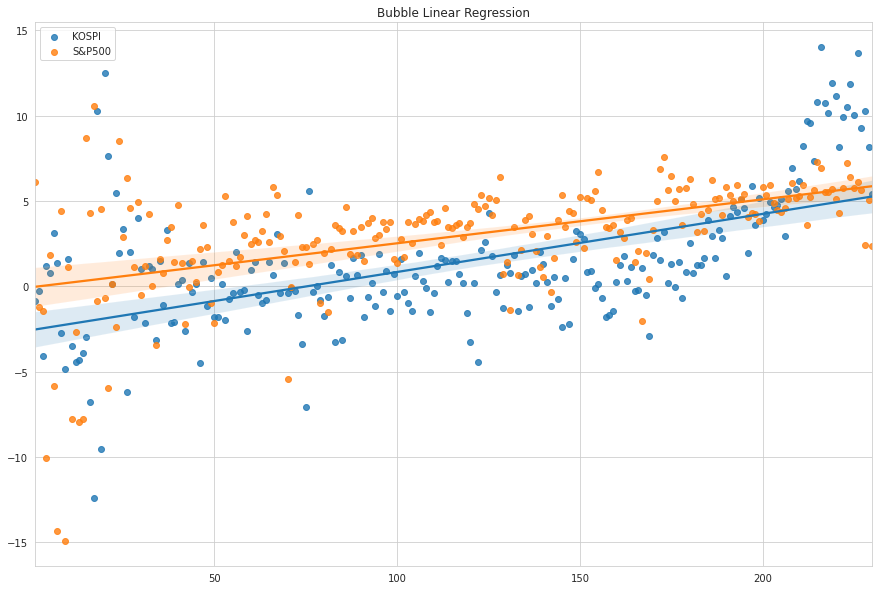

In [ ]:
# 버블 관측치에 대한 regression

fig = plt.figure(figsize=(15,10))
sns.regplot(X,ks_per_slice,label="KOSPI")
sns.regplot(X,sp_per_slice,label="S&P500")
plt.title("Bubble Linear Regression")
plt.legend()